In [1]:
import json
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.stats import linregress


In [128]:
#Create file path and read in the file

health_data_path= "Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System (version 1).csv"
read_data = pd.read_csv(health_data_path)
read_data.head()

,"eek, an",YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value_Unit,Data_Value_Type,...,GeoLocation,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2011,2011,AK,Alaska,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(64.845079957001, -147.722059036)",OWS,OWS1,Q037,VALUE,2,Income,"$15,000 - $24,999",INC,INC1525
1,2011,2011,AK,Alaska,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(64.845079957001, -147.722059036)",OWS,OWS1,Q037,VALUE,2,Age (years),35 - 44,AGEYR,AGEYR3544
2,2011,2011,AK,Alaska,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(64.845079957001, -147.722059036)",OWS,OWS1,Q037,VALUE,2,Income,"Less than $15,000",INC,INCLESS15
3,2011,2011,AK,Alaska,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(64.845079957001, -147.722059036)",OWS,OWS1,Q037,VALUE,2,Income,"$35,000 - $49,999",INC,INC3550
4,2011,2011,AK,Alaska,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(64.845079957001, -147.722059036)",OWS,OWS1,Q037,VALUE,2,Race/Ethnicity,Hispanic,RACE,RACEHIS


In [4]:
# Extract only the columns needed
new_df = pd.DataFrame(read_data[["YearEnd","LocationDesc","Question","Data_Value"]])

# Extract data from only year 2017 - air quality data only contains info for 2017
clean_df = new_df.loc[new_df.YearEnd == 2017]
clean_df.head()

In [131]:
# Group dataframe by question and take the average of the data values. Rename columns

final_health_data = pd.DataFrame(clean_df.groupby(["Question", "LocationDesc"]).mean()["Data_Value"].reset_index()).rename(columns= {"LocationDesc": "state"})
final_health_data.head()

,Question,state,Data_Value
0,Percent of adults aged 18 years and older who ...,Alabama,33.792000
1,Percent of adults aged 18 years and older who ...,Alaska,31.858333
2,Percent of adults aged 18 years and older who ...,Arizona,34.707407
3,Percent of adults aged 18 years and older who ...,Arkansas,36.272000
4,Percent of adults aged 18 years and older who ...,California,35.670370


In [132]:
# Determined that there are some outlier states - Puerto Rico and Virgin Islands. Drop these states

final_health = final_health_data[(final_health_data.state != "Puerto Rico") & (final_health_data.state != "Virgin Islands")]
final_health.describe()

,Data_Value
count,477.000000
mean,31.091032
std,9.077989
min,13.350000
25%,25.172000
50%,30.804167
75%,35.164000
max,58.243478


In [133]:
# Questions #3-6 are very similar and we want to consolidate those. Replace each question with a shortened statement to read easier

condense_health = final_health.replace(to_replace = "Percent of adults aged 18 years and older who have an overweight classification", value ="overweight").replace(to_replace ="Percent of adults aged 18 years and older who have obesity", value = "obese").replace(to_replace ="Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)", value ="moderate-intense physical activity").replace(to_replace ="Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week", value ="moderate-intense physical activity").replace(to_replace ="Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)", value ="moderate-intense physical activity").replace(to_replace ="Percent of adults who engage in muscle-strengthening activities on 2 or more days a week", value ="moderate-intense physical activity").replace(to_replace ="Percent of adults who engage in no leisure-time physical activity", value ="no physical activity").replace(to_replace ="Percent of adults who report consuming fruit less than one time daily", value ="less than one fruit per day").replace(to_replace ="Percent of adults who report consuming vegetables less than one time daily", value ="less than one vegetable per day")

In [134]:
# Print unique question in health datadrame to ensure the replace funciton worked
condense_health.head()
condense_health["Question"].unique()

array(['overweight', 'obese', 'moderate-intense physical activity',
       'no physical activity', 'less than one fruit per day',
       'less than one vegetable per day'], dtype=object)

In [135]:
# Parameters for API Health Data url

email = "lilu216@hotmail.com"
api_key = "baygoose48"
base_url = "https://aqs.epa.gov/data/api/annualData/byState?"
param = "42602"
bdate = "20180101"
edate = "20181231"

# Sample request
url_alabama_co = f"{base_url}email={email}&key={api_key}&param={param}&bdate={bdate}&edate={edate}&state=01"
response = requests.get(url_alabama_co).json()

#print(json.dumps(response, indent=4, sort_keys=True))

In [136]:
# Set up query url

state_query_url = f"{base_url}email={email}&key={api_key}&param={param}&bdate={bdate}&edate={edate}&state="

# Set up empty lists for data in each column
states = []
mean = []
max_value = []

# Create a list of state codes so our request can loop through and pull each state
state_code = ["01", "02", "04", "05", "06", "08", "09", "10", "11", "12", "13", "15", "16", "17", "18", "19", "20", "21", "22", 
              "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41",
              "42", "44", "45", "46", "47", "48", "49", "50", "51", "53", "54", "55", "56", "66", "72", "78"]

# Loop through each state code and pull mean and max No2 values for all locations in each state
for code in state_code:
    response = requests.get(state_query_url + code).json()
    try:
        states.extend([x['state'] for x in response['Data']])
        mean.extend([x['arithmetic_mean'] for x in response['Data']])
        max_value.extend([x['first_max_value'] for x in response['Data']])

    except: 
        print("This state has no data", code)

In [137]:
# create a dictionary of lists
no2_dict = {
    "state": states,
    "No2": mean,
    "max No2": max_value,
}

# Create a dataframe from lists
no_2_df = pd.DataFrame(no2_dict)
no_2_df.head()

,state,No2,max No2
0,Alabama,8.185029,41.7
1,Alabama,20.214454,41.7
2,Alabama,11.090790,49.8
3,Alabama,23.718644,49.8
4,Alaska,11.618211,69.1


In [138]:
# Group dataframe by state and calculate the mean for No2 levels and the max for max No2 levels
# Rename columns so that are no longer in tuples

clean_air_df = no_2_df.groupby("state").agg({"No2": "mean", "max No2": "max"}).reset_index()
clean_air_df.rename(columns="".join, inplace=True)
clean_air_df.head()

,state,No2,max No2
0,Alabama,15.802229,49.8
1,Alaska,16.739653,69.1
2,Arizona,22.405089,75.0
3,Arkansas,12.396318,45.1
4,California,14.425014,90.3


In [139]:
# Create seperate dataframes for specific questions: "Phyisical Acivity" and "No Physical Activity"

active_df = condense_health.loc[condense_health.Question == "moderate-intense physical activity"]
no_active_df = condense_health.loc[condense_health.Question == "no physical activity"]

In [140]:
active_df

,Question,state,Data_Value
110,moderate-intense physical activity,Alabama,42.492000
111,moderate-intense physical activity,Alaska,57.166667
112,moderate-intense physical activity,Arizona,51.222222
113,moderate-intense physical activity,Arkansas,44.900000
114,moderate-intense physical activity,California,57.285185
...,...,...,...
325,moderate-intense physical activity,Virginia,32.542308
326,moderate-intense physical activity,Washington,32.414815
327,moderate-intense physical activity,West Virginia,23.134783
328,moderate-intense physical activity,Wisconsin,30.650000


In [141]:
# Because we consolidated 4 similar questions into one, we need to groupby state again

active_df = active_df.groupby("state").agg({"Data_Value": "mean", "Question": "max"}).reset_index()
active_df.rename(columns="".join, inplace=True)
active_df.head()

,state,Data_Value,Question
0,Alabama,27.654000,moderate-intense physical activity
1,Alaska,38.219792,moderate-intense physical activity
2,Arizona,34.044444,moderate-intense physical activity
3,Arkansas,28.683000,moderate-intense physical activity
4,California,37.912963,moderate-intense physical activity


In [142]:
# Merge each dataframe with the air data

merged_active = pd.merge(active_df, clean_air_df, on="state")
merged_no_active = pd.merge(no_active_df, clean_air_df, on="state")

In [143]:
merged_no_active.head()

,Question,state,Data_Value,No2,max No2
0,no physical activity,Alabama,32.412000,15.802229,49.8
1,no physical activity,Alaska,21.308333,16.739653,69.1
2,no physical activity,Arizona,26.059259,22.405089,75.0
3,no physical activity,Arkansas,33.324000,12.396318,45.1
4,no physical activity,California,20.700000,14.425014,90.3


In [157]:
merged_active.head()

,state,Data_Value,Question,No2,max No2
0,Alabama,27.654000,moderate-intense physical activity,15.802229,49.8
1,Alaska,38.219792,moderate-intense physical activity,16.739653,69.1
2,Arizona,34.044444,moderate-intense physical activity,22.405089,75.0
3,Arkansas,28.683000,moderate-intense physical activity,12.396318,45.1
4,California,37.912963,moderate-intense physical activity,14.425014,90.3


In [145]:
# Use a function to create a scatter plot and calculate the regression line
# Use with or without line annotation

def scatter_plot(x_axis, y_axis, show_regress=True, suptitle="", title="", ylabel="", xlabel=""):  
    plt.scatter(x_axis, y_axis)
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
    line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
    regress_line = x_axis * slope + intercept
    plt.plot(x_axis,regress_line,"r-")
#     plt.annotate(line_eq,(x_axis.mean(),y_axis.min()),fontsize=16,color="red")
#     x_axis.mean()
#     y_axis.mean()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.suptitle(suptitle)
    plt.title(title)
    plt.grid()
    print(f"The r-squared is: {rvalue}")

The r-squared is: 0.3162863682062775


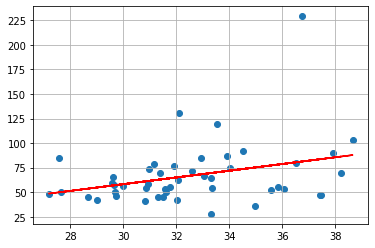

In [146]:
# No2 levels compared to physical activity
scatter_plot(merged_active["Data_Value"], merged_active["max No2"], True)
# plt.xlabel("No2")
# plt.ylabel("Active")
plt.show()
print(f"This data shows that states reporting higher max No2 levels also report higher percentage of physically active people")

The r-squared is: -0.352044704552981


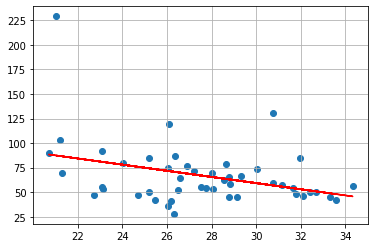

In [158]:
# No2 levels compared to no physical activity
scatter_plot(merged_no_active["Data_Value"], merged_no_active["max No2"], True)
# plt.xlabel("No2")
# plt.ylabel("Active")
plt.show()
print(f"This data shows that states reporting lower max No2 levels also report lower percentage of physically active people")

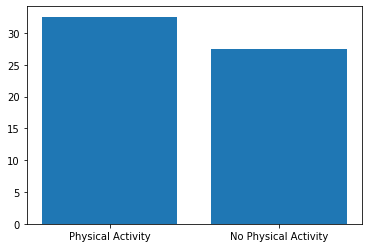

In [73]:
# Percent of people who report being phyically active vs. percent of people who report not being physically active

questions = final_health_data["Question"].unique()
labels = ["Physical Activity", "No Physical Activity"]
mean = [active_prct_mean.mean(), no_active_prct_mean.mean()]

x_axis = np.arange(0, len(labels))
tick_locations = []

for x in x_axis:
    tick_locations.append(x)
    
plt.bar(questions[2:4], mean)
plt.xticks(tick_locations, labels)
plt.show()